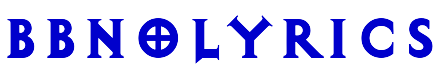
# <b> Bbno$ Song Lyrics Analysis : Most Used Words Revealed with Python.</b>

#### In this Jupyter notebook project, I used the BeautifulSoup library to scrape the lyrics of songs by the artist "bbno$".
#### First, I scraped the entire song titles of bbno$ using BeautifulSoup from the website genius.com.
#### Next, I used those titles to scrape the lyrics for each song using BeautifulSoup from the same website.
#### Then, I squished all the words into a single list by combining the lyrics of all the songs.
#### Finally, I used the Counter class from the collections module to count how many times each word appeared in the list.

In [25]:
# import necessary modules

from bs4 import BeautifulSoup
import requests
import pandas as pd

## <b>Retrieve track titles and artist names.
#### In order to form a list of pairs in this format ['song title', 'artist'] I visited genius.com and saved an html page displaying the entire discography of bbno$.
#### The page looks like the following:
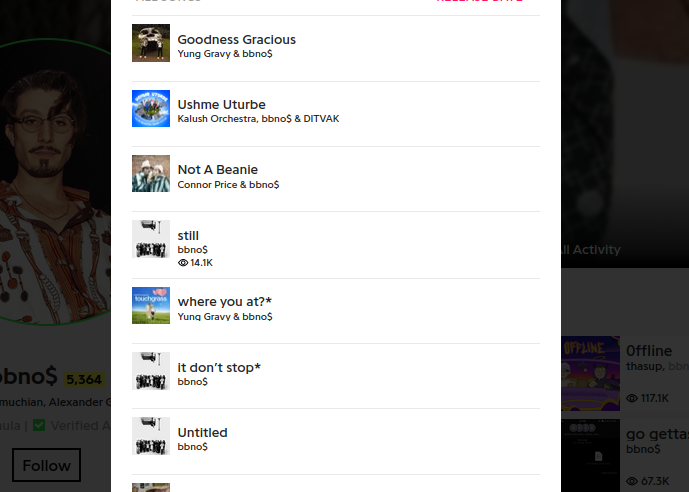<br>File path : /html_page/discography.html
#### Now let's use webscraping to iterate through HTML elements and extract the titles and the artits involved in each track.

In [26]:
# Open the file then parse it with bs4
with open("discoraphy_html/discography.html") as f:
    soup = BeautifulSoup(f, 'html.parser')

In [27]:
# Retrieve the <div> element representing the white window
tracks_div = soup.find('div', {'class' : 'modal_window-content modal_window-content--narrow_width modal_window-content--white_background'})

# Extract <div> elements that belong to the title class
titles_div = tracks_div.find_all('div', {'class': 'mini_card-title'})
# Same procedure for the artits
artist_div = tracks_div.find_all('div', {'class': 'mini_card-subtitle'})

# Sanity check
len(titles_div) == len(artist_div)

True

In [28]:
# Merge their respective innerHTMLs into a list
tracks = [[t.text, a.text] for t, a in zip(titles_div, artist_div)]

# Remove remaining unicode characters
for i in range(len(tracks)):
    for j in range(2):
        tracks[i][j] = tracks[i][j].replace('\n', '').replace('\u200b', '')

pd.DataFrame(tracks, columns=['Title', 'Artist'])

,Title,Artist
0,Goodness Gracious,Yung Gravy & bbno$
1,Ushme Uturbe,"Kalush Orchestra, bbno$ & DITVAK"
2,Not A Beanie,Connor Price & bbno$
3,still,bbno$
4,where you at?*,Yung Gravy & bbno$
...,...,...
266,Puma,$NOT
267,improvisation,bbno$
268,tamagotchi*,bbno$
269,property*,bbno$


## <b>Now let's eliminate unrealeased tracks.</b>
#### Titles ending with an asterix('*') indicate that the song was never officially released.
#### We must also filter out remixes because they contain redundant lyrics.

In [29]:
official_tracks = []

for track in tracks:
        if track[0][-1] == '*' or 'remix' in track[0].lower():
                pass
        else:
                official_tracks.append(track)
                
pd.DataFrame(official_tracks, columns=['Title', 'Artist'])

,Title,Artist
0,Goodness Gracious,Yung Gravy & bbno$
1,Ushme Uturbe,"Kalush Orchestra, bbno$ & DITVAK"
2,Not A Beanie,Connor Price & bbno$
3,still,bbno$
4,Untitled,bbno$
...,...,...
240,Dumb lit,Lucid Monday & bbno$
241,Bad thot,LUX (luxlafuego)
242,centerfold,bbno$
243,Puma,$NOT


In [30]:
# There are some unreleased tracks that do not end with an asterix, instead they have a (Unreleased) legend attached to them
# I will have to manually delete them :(
Unreleased_titles = ['Untitled #2', 'Pussy Boy', 'Crunch It Up', 'simulation', 'BB$xOT', 'Bad thot']
official_tracks_2 = []

for t in official_tracks:
    if t[0] in Unreleased_titles:
        pass
    else:
        official_tracks_2.append(t)


# <b>Retrive lyrics for each song.</b>
### Again, we will be using webscraping to obtain song lyrics, only this time it would be exausting to manually download the html pages for each track.
### Instead, we are going to construct a URL in this format: https://genius.com/Bbno-yung-gravy-and-lentra-jack-money-bean-lyrics, and use it to obtain the HTML code.
### The genius.com URL is composed of:
<ol>
<h5>
<li>The base part "https://genius.com/"</li>
<li>The artist's username.</li>
<li>The track's title.</li>
<li>The "lyrics" parameter.</li>
</h5>
<p><i>Keep in mind all that the strings must be seperated by a ' - ' character .</i></p>
</ol>

### First let's prepare our strings for the URL.

In [31]:
# Modify strings to fit the genius URL 
def fit_to_url(tracklist):
    tracklist_formatted = []
    for track in tracklist:
        track[0] = '-'.join(track[0].replace('!', '').replace('?','').replace('(', '').replace(')', '').replace('/', '-').split())
        track[1] = '-'.join(track[1].split())
        track[1] = track[1].replace(' ', '').replace(',', '').replace('&', 'and').replace('$', '')
        tracklist_formatted.append(track)
    return tracklist_formatted

In [32]:
official_tracks = fit_to_url(official_tracks_2)
pd.DataFrame(official_tracks, columns=['Title', 'Artist'])

,Title,Artist
0,Goodness-Gracious,Yung-Gravy-and-bbno
1,Ushme-Uturbe,Kalush-Orchestra-bbno-and-DITVAK
2,Not-A-Beanie,Connor-Price-and-bbno
3,still,bbno
4,Untitled,bbno
...,...,...
234,Stupid,Lucid-Monday-and-bbno
235,Dumb-lit,Lucid-Monday-and-bbno
236,centerfold,bbno
237,Puma,NOT


## Let's test this on a random song.

In [42]:
import random

index = random.randint(0, len(official_tracks)-1)

test_url = "https://genius.com/" + official_tracks[index][1] + "-" + official_tracks[index][0] + "-lyrics"
test_url

'https://genius.com/Crispy-Concords-whatchu-mean-lyrics'

## <span style="color:green">Seems to work :)</span>
### Now let's scrape the page for lyrics.

In [43]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

# Get HTML
page = requests.get(test_url, headers)
soup = BeautifulSoup(page.text, 'html.parser')

# Extract <div> elements that belong to the lyrics class
lyrics_div = soup.find_all('div', {'class' : 'Lyrics__Container-sc-1ynbvzw-5 Dzxov'})
lyrics_div

[<div class="Lyrics__Container-sc-1ynbvzw-5 Dzxov" data-lyrics-container="true">[Intro: bbno$]<br/><a class="ReferentFragmentdesktop__ClickTarget-sc-110r0d9-0 cesxpW" href="/24603753/Crispy-concords-whatchu-mean/Ayy-man-the-the-fuck-you-mean-you-aint-heard-no-fuckin-lentra-the-god"><span class="ReferentFragmentdesktop__Highlight-sc-110r0d9-1 jAzSMw"><i>Ayy, man, the-, the fuck you mean you ain't heard no fuckin' Lentra the God?</i></span></a><span style="position:absolute;opacity:0;width:0;height:0;pointer-events:none;z-index:-1" tabindex="0"></span><span><span style="position:absolute;opacity:0;width:0;height:0;pointer-events:none;z-index:-1" tabindex="0"></span><span style="position:absolute;opacity:0;width:0;height:0;pointer-events:none;z-index:-1" tabindex="0"></span></span><br/><a class="ReferentFragmentdesktop__ClickTarget-sc-110r0d9-0 cesxpW" href="/24600698/Crispy-concords-whatchu-mean/Im-in-austin-for-the-first-time-ever-and-im-kinda-horny-and-shit"><span class="ReferentFragme

In [44]:
lyrics_lines = []
# Extract lines
for line in lyrics_div:
    lyrics_lines.append(line.get_text(separator='<br>').split('<br>'))

# Sometimes the lyrics are split into seperate <div> elements
temp = []
for i in range(len(lyrics_lines)):
    temp += lyrics_lines[i]
lyrics_lines = temp

pd.DataFrame(lyrics_lines, columns=['Lines']).head()

,Lines
0,[Intro: bbno$]
1,"Ayy, man, the-, the fuck you mean you ain't he..."
2,"I'm in Austin for the first time ever, and I'm..."
3,[Chorus: bbno$]
4,Whatchu mean by that? (Huh?) I'm curious


In [45]:
import re

def lyrics_cleaner(lines):
    clean_lines = []
    pattern = r'\[.*?\]'
    for i in range(len(lines)):
        lines[i] = re.sub(pattern, '', lines[i])
        if '\u200b' in lines[i] or len(lines[i]) < 2:
            pass
        else:
            lines[i] = lines[i].replace('!', '').replace('?','').replace('(', '').replace(')', '').replace(',', '')
            clean_lines.append(lines[i].lower())
    return clean_lines

In [46]:
lyrics_lines = lyrics_cleaner(lyrics_lines)

# Squish all song words into a list
words = [word for line in lyrics_lines for word in line.split()]
pd.DataFrame(words, columns=['Words'])

,Words
0,ayy
1,man
2,the-
3,the
4,fuck
...,...
391,in
392,your
393,mouth
394,ayy


### Finally, we apply the same steps on all the songs.
# <b>Retrive lyrics for each song.</b>

In [48]:
all_words = []

In [50]:
# Due to timeout constraints, I had to divide the list of tracks into four sections and retrieve the data for each section sequentially.
# SECTION 1
for track in official_tracks[0:60]:
    URL = "https://genius.com/" + track[1] + "-" + track[0] + "-lyrics"
    page = requests.get(URL, headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    lyrics_div = soup.find_all('div', {'class' : 'Lyrics__Container-sc-1ynbvzw-5 Dzxov'})
    
    lyrics_lines = []
    for line in lyrics_div:
        lyrics_lines.append(line.get_text(separator='<br>').split('<br>'))

    temp = []
    for i in range(len(lyrics_lines)):
        temp += lyrics_lines[i]
    lyrics_lines = temp

    lyrics_lines = lyrics_cleaner(lyrics_lines)
    words = [word for line in lyrics_lines for word in line.split()]
    for word in words:
        all_words.append(word)

In [51]:
# SECTION 2
for track in official_tracks[60:120]:
    URL = "https://genius.com/" + track[1] + "-" + track[0] + "-lyrics"
    page = requests.get(URL, headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    lyrics_div = soup.find_all('div', {'class' : 'Lyrics__Container-sc-1ynbvzw-5 Dzxov'})
    
    lyrics_lines = []
    for line in lyrics_div:
        lyrics_lines.append(line.get_text(separator='<br>').split('<br>'))

    temp = []
    for i in range(len(lyrics_lines)):
        temp += lyrics_lines[i]
    lyrics_lines = temp

    lyrics_lines = lyrics_cleaner(lyrics_lines)
    words = [word for line in lyrics_lines for word in line.split()]
    for word in words:
        all_words.append(word)

In [52]:
# SECTION 3
for track in official_tracks[120:180]:
    URL = "https://genius.com/" + track[1] + "-" + track[0] + "-lyrics"
    page = requests.get(URL, headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    lyrics_div = soup.find_all('div', {'class' : 'Lyrics__Container-sc-1ynbvzw-5 Dzxov'})
    
    lyrics_lines = []
    for line in lyrics_div:
        lyrics_lines.append(line.get_text(separator='<br>').split('<br>'))

    temp = []
    for i in range(len(lyrics_lines)):
        temp += lyrics_lines[i]
    lyrics_lines = temp

    lyrics_lines = lyrics_cleaner(lyrics_lines)
    words = [word for line in lyrics_lines for word in line.split()]
    for word in words:
        all_words.append(word)

In [53]:
# SECTION 4
for track in official_tracks[180:239]:
    URL = "https://genius.com/" + track[1] + "-" + track[0] + "-lyrics"
    page = requests.get(URL, headers)
    soup = BeautifulSoup(page.text, 'html.parser')

    lyrics_div = soup.find_all('div', {'class' : 'Lyrics__Container-sc-1ynbvzw-5 Dzxov'})
    
    lyrics_lines = []
    for line in lyrics_div:
        lyrics_lines.append(line.get_text(separator='<br>').split('<br>'))

    temp = []
    for i in range(len(lyrics_lines)):
        temp += lyrics_lines[i]
    lyrics_lines = temp

    lyrics_lines = lyrics_cleaner(lyrics_lines)
    words = [word for line in lyrics_lines for word in line.split()]
    for word in words:
        all_words.append(word)

In [54]:
pd.DataFrame(all_words, columns=['Words'])

,Words
0,uh
1,goodness
2,gracious
3,tito's
4,got
...,...
99408,boy
99409,huh
99410,like
99411,baby


# <b>Count each word from the list.</b>

In [68]:
from collections import Counter

word_counts = Counter(word for word in all_words if len(word) >= 4)

most_common = word_counts.most_common()
df = pd.DataFrame(most_common, columns=['Word', 'Count'])

df[:20]

,Word,Count
0,yeah,1353
1,like,1144
2,that,1047
3,with,763
4,your,763
5,bitch,673
6,money,608
7,don't,591
8,baby,586
9,shit,559


In [66]:
# Honorable Mention
print(word_counts["sussy"])

57


### Save results into a csv file.

In [56]:
df.to_csv('word_count_data/word_counts.csv', index=False)